<a href="https://colab.research.google.com/github/greygrease/tf-stuff/blob/main/09_SkimLit_NLP_Projectipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

NLP model to make medical abstracts reading easier

https://arxiv.org/abs/1710.06071 [NN for joint sentence classification]

https://arxiv.org/abs/1612.05251 [PubMed 200k RCT]

In [1]:
!nvidia-smi

Wed Sep 21 17:23:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Download the dataset used in Pubmed https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data


In [5]:
# Create func to read the lines of a document

def getlines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [6]:
# Reading Training lines
train_lines = getlines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def preprocess_text_with_line_numbers(filename):
  input_lines = getlines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract 
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line
  return abstract_samples

In [8]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [9]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
train_df.head(12)

,target,text,line number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribuition of labels in training data

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

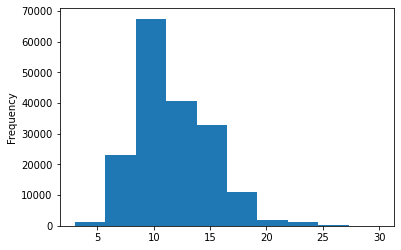

In [13]:
# Lets checek thel enght of different lines

train_df.total_lines.plot.hist()

### Get list of sentences



In [14]:
# Convert abstract text lines into lists

train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [15]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)



In [16]:
# One hot encoding labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))


In [17]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
### Encoding labels

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

In [19]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Series of modelling experiments



### Model 0 : Getting a baseline 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model

model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model

baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-21 17:24:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-21 17:24:12 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
 # Cal baesline results

 baseline_results = calculate_results(y_true = val_labels_encoded,
                                      y_pred = baseline_preds )

In [26]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for our deep squence models

Before we start we got to create vectoriztion and embedding layers

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

(array([2.5486e+04, 7.1478e+04, 4.8888e+04, 2.0260e+04, 7.5560e+03,
        3.4370e+03, 1.4950e+03, 7.3700e+02, 3.2800e+02, 1.6500e+02,
        8.5000e+01, 4.9000e+01, 2.0000e+01, 1.5000e+01, 9.0000e+00,
        6.0000e+00, 8.0000e+00, 8.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,  12.8,  24.6,  36.4,  48.2,  60. ,  71.8,  83.6,  95.4,
        107.2, 119. , 130.8, 142.6, 154.4, 166.2, 178. , 189.8, 201.6,
        213.4, 225.2, 237. , 248.8, 260.6, 272.4, 284.2, 296. ]),
 <a list of 25 Patch objects>)

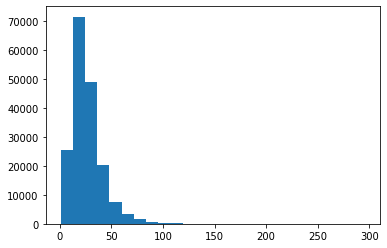

In [29]:
# What does the distribution look lik

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 25)

In [30]:
# How long of a sentence lenght convers 95% of examples

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorizer layer

In [31]:
# How many words are in our vocab
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer  = TextVectorization(max_tokens = max_tokens,
                                     output_sequence_length= output_seq_len)

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences

import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text\n: {len(target_sentence)}')
print(f'\nVectorizes test\n:{text_vectorizer([target_sentence])}')

Text:
 we randomly assigned @ patients undergoing coronary stent follow-up with the use of mdct-ca to iomeprol-@ at @ ml/sec flow rate ( group @ ; n = @ ) , iodixanol-@ at @ ml/sec flow rate ( group @ ; n = @ ) , and iodixanol-@ at @ ml/sec flow rate ( group @ ; n = @ ) .

Length of text
: 265

Vectorizes test
:[[   43    92   123    12   295   346   788    94     7     2    87     4
  22584     6 20372    15 25715   765    78    13    40  8249    15 25715
    765    78    13    40     3  8249    15 25715   765    78    13    40
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How mnay owrds in our training vocab

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding




In [37]:
# Create tokem embeddging layer

token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128, 
                               mask_zero = True, # Hanndle variable seq length
                               name = 'token_embedding')       

In [38]:
# Show example embedding
print(f'Before Vectoriztion:\n{target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'After Vectorization:\n {vectorized_sentence}\n')
embeded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embeded_sentence}\n')
print(f'Embedded sentence shape:\n {embeded_sentence.shape}')

Before Vectoriztion:
we randomly assigned @ patients undergoing coronary stent follow-up with the use of mdct-ca to iomeprol-@ at @ ml/sec flow rate ( group @ ; n = @ ) , iodixanol-@ at @ ml/sec flow rate ( group @ ; n = @ ) , and iodixanol-@ at @ ml/sec flow rate ( group @ ; n = @ ) .

After Vectorization:
 [[   43    92   123    12   295   346   788    94     7     2    87     4
  22584     6 20372    15 25715   765    78    13    40  8249    15 25715
    765    78    13    40     3  8249    15 25715   765    78    13    40
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.04557025 -0.04482988  0.00214616 ... -0.01043286 -0.01294721
   -0.013142  ]
  [-0.01660801  0.04813278  0.03976775 ... -0.04022515 -0.00014774
   -0.0341531 ]
  [ 0.03023214  0.02161975 -0.03117187 ...  0.03906456  0.04605016
   -0.04867731]
  ...
  [ 0.04960265 -0.02779397  0.00827182 ... -0.01893594  0.0065956

## Creating datasets(making sure our data loads as fast as possible)



In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

In [40]:
# Turn dataets into prefetched
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

 ## Model 1: Conv1D with token embeddings
 

In [41]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [42]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x  = layers.Conv1D(64,kernel_size = 5, padding = 'same', activation = 'relu' )(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [43]:
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [44]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 9ms/step - loss: 0.9218 - accuracy: 0.6379 - val_loss: 0.6849 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6554 - accuracy: 0.7596 - val_loss: 0.6326 - val_accuracy: 0.7733
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6143 - accuracy: 0.7754 - val_loss: 0.5960 - val_accuracy: 0.7872


In [45]:
# Eval on whole valid dataest
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5955 - accuracy: 0.7864


[0.5955380201339722, 0.7864424586296082]

In [46]:
model_1_pred_probs = model_1.predict(valid_dataset)

In [47]:
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.7332230e-01, 1.6064334e-01, 4.5603827e-02, 2.9831412e-01,
         2.2116393e-02],
        [3.9467707e-01, 3.5362092e-01, 1.3397161e-02, 2.2786391e-01,
         1.0440831e-02],
        [1.6648260e-01, 6.1896485e-03, 1.4938093e-03, 8.2580888e-01,
         2.5142692e-05],
        ...,
        [1.5347114e-05, 1.0489220e-03, 1.0849152e-03, 7.4965596e-06,
         9.9784327e-01],
        [4.5058936e-02, 4.4651550e-01, 8.4204413e-02, 4.8312835e-02,
         3.7590840e-01],
        [1.8919629e-01, 6.8255836e-01, 5.0596487e-02, 4.2380970e-02,
         3.5267949e-02]], dtype=float32), (30212, 5))

In [48]:
# Convert pred probs to classes 

model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)

In [50]:
model_1_results

{'accuracy': 78.64424731894611,
 'precision': 0.7836621296998662,
 'recall': 0.7864424731894611,
 'f1': 0.7841446924764106}

In [51]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model_2 Feature Extraction model

Now lets use pretrained word embedding in tensorflow hub

The paper originally used Glove embedding but we are using Universal Sentence Encoder

In [52]:
# Download USE

import tensorflow_hub as hub

hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                 trainable = False,
                                 name = 'Universal_Sentence_Encoder')

In [53]:
# Test USE

random_train_sentence = random.choice(train_sentences)
print('Random sent:\n')
print(random_train_sentence)

use_embedded_sentence = hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n')
print(use_embedded_sentence)

Random sent:

bereaved next of kin ( n = @ ) of veterans who died between @ and @ .
Sentence after embedding:

tf.Tensor(
[[ 3.67224403e-02 -1.36752855e-02  3.03303301e-02 -1.68410055e-02
  -3.87651287e-02 -9.35577601e-02 -2.07951069e-02 -2.57481635e-02
  -8.59659240e-02 -2.92533822e-02  9.24727246e-02  6.04705401e-02
   5.47717651e-03 -5.85419051e-02  3.31283808e-02 -8.04240853e-02
  -9.53920260e-02 -5.91751710e-02 -4.53332551e-02 -5.93169965e-02
   7.74881169e-02  1.04501555e-02  9.41909999e-02 -3.68131362e-02
   2.08034199e-02  6.81828633e-02 -4.78349067e-02 -3.92089523e-02
  -4.04850207e-02  3.07639316e-02 -5.35007678e-02  6.90589845e-02
  -2.88014133e-02 -5.78553639e-02 -4.98768836e-02  1.68376304e-02
   6.55228943e-02 -7.24791363e-03 -5.07196598e-02 -2.85907779e-02
   5.67135736e-02 -3.00247762e-02 -6.26403838e-03  1.37231657e-02
   1.16867255e-02  2.29519457e-02  2.55660582e-02  4.80804686e-03
   1.39287952e-02  2.78759114e-02 -3.93212475e-02  2.85227839e-02
   2.80353893e-02 -5

In [54]:
len(use_embedded_sentence[0])

512

In [55]:
# Create Model_2 (feature extraction model)

inputs = layers.Input(shape=[], dtype = tf.string)
embedding = hub_embedding_layer(inputs)
# x = layers.Conv1D(64,kernel_size = 4, padding = 'same', activation = 'relu')(embedding)
# x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation = 'relu')(embedding)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

In [56]:
# COmpile model 2
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [57]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_Sentence_Encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [58]:
# Fit the model

history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9202 - accuracy: 0.6480 - val_loss: 0.7975 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7691 - accuracy: 0.7016 - val_loss: 0.7540 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7517 - accuracy: 0.7126 - val_loss: 0.7374 - val_accuracy: 0.7154


In [59]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7408 - accuracy: 0.7144


[0.7408158779144287, 0.7143850326538086]

In [60]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.1177526e-01, 3.7497774e-01, 2.5565510e-03, 2.0175663e-01,
        8.9337863e-03],
       [3.2509923e-01, 5.0701475e-01, 3.5754854e-03, 1.6082768e-01,
        3.4828454e-03],
       [2.3712763e-01, 1.6383563e-01, 2.0424468e-02, 5.4120106e-01,
        3.7411187e-02],
       ...,
       [1.4689747e-03, 6.1363475e-03, 5.2214932e-02, 8.4117125e-04,
        9.3933856e-01],
       [3.1938457e-03, 4.4137690e-02, 1.9945091e-01, 1.3501603e-03,
        7.5186741e-01],
       [1.7036517e-01, 3.0216941e-01, 4.6215737e-01, 5.0693327e-03,
        6.0238738e-02]], dtype=float32)

In [61]:
# Convert the prediction probs tolabels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [62]:
# Calculate results from pretrained embedding 
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.43850125777837,
 'precision': 0.7155717626234269,
 'recall': 0.7143850125777836,
 'f1': 0.7115514793138659}

## Model3 : Conv1D with character level tokenization

The paper we are replicating used char lvl embedding and world lvl embedding

### Creating a char level tokenizer



In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [64]:
def split_chars(text):
  return ' '.join(list(text))

In [65]:
# Split sequence level data splits into char level data spilts

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for  sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [66]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

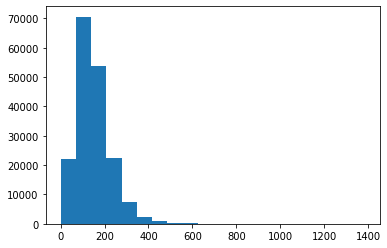

In [67]:
# Check the distribution of the sequences at a char level

import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 20)

In [68]:
# Find what char lenght covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char lvl token vectorizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2 # '+2' for space and OOV
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    # standardize = None,
                                    name = 'char_vectorizer')

In [71]:
# Adapt char vectorizer to training character

char_vectorizer.adapt(train_chars)

In [72]:
# Check char vocab stats 
char_vocab = char_vectorizer.get_vocabulary()
print(f'Num of diff char {len(char_vocab)}')
print(f'5 most common char: {char_vocab[:5]}')
print(f'% least common char: {char_vocab[-5:]}')

Num of diff char 28
5 most common char: ['', '[UNK]', 'e', 't', 'i']
% least common char: ['k', 'x', 'z', 'q', 'j']


In [73]:
# Test  out our char vectorizer

random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'Len of random_train_char:{len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vectorized chars:\n {vectorized_chars}')
print(f'Len of vectorized chars:{len(vectorized_chars[0])}')

Charified text:
 s a m a t a s v i r   i s   b e i n g   e v a l u a t e d   i n   c o m b i n a t i o n   w i t h   o t h e r   d i r e c t - a c t i n g   a n t i v i r a l   a g e n t s   i n   s u b j e c t s   w i t h   h c v   i n f e c t i o n   .
Len of random_train_char:103
Vectorized chars:
 [[ 9  5 15  5  3  5  9 21  4  8  4  9 22  2  4  6 18  2 21  5 12 16  5  3
   2 10  4  6 11  7 15 22  4  6  5  3  4  7  6 20  4  3 13  7  3 13  2  8
  10  4  8  2 11  3  5 11  3  4  6 18  5  6  3  4 21  4  8  5 12  5 18  2
   6  3  9  4  6  9 16 22 27  2 11  3  9 20  4  3 13 13 11 21  4  6 17  2
  11  3  4  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0

## Creating a char level embedding



In [74]:
# Create char lvl embedding

char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name = 'char_embed')

In [75]:
# Test our char embedding layer
print(f'Charified text:\n {random_train_chars}')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars: \n {char_embed_example}')
print(f'Char embedding shape: {char_embed_example.shape}')

Charified text:
 s a m a t a s v i r   i s   b e i n g   e v a l u a t e d   i n   c o m b i n a t i o n   w i t h   o t h e r   d i r e c t - a c t i n g   a n t i v i r a l   a g e n t s   i n   s u b j e c t s   w i t h   h c v   i n f e c t i o n   .
Embedded chars: 
 [[[ 0.00888921  0.02177718 -0.03401557 ... -0.02613834 -0.01599114
    0.0085637 ]
  [-0.03563682  0.02746055 -0.01382481 ...  0.01997926 -0.02317023
    0.03928849]
  [ 0.02172576  0.02143406 -0.00887288 ... -0.04192891 -0.02551976
    0.01481701]
  ...
  [ 0.03603632  0.03247471 -0.04593767 ... -0.0035864  -0.02656955
    0.0177195 ]
  [ 0.03603632  0.03247471 -0.04593767 ... -0.0035864  -0.02656955
    0.0177195 ]
  [ 0.03603632  0.03247471 -0.04593767 ... -0.0035864  -0.02656955
    0.0177195 ]]]
Char embedding shape: (1, 290, 25)


## Model 3 

In [76]:
# Create the model

inputs = layers.Input(shape = (1,), dtype= tf.string)
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_char')

In [77]:
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [94]:
# Create char lvl datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2726 - accuracy: 0.4815 - val_loss: 1.0353 - val_accuracy: 0.5967
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0023 - accuracy: 0.5978 - val_loss: 0.9336 - val_accuracy: 0.6260
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9230 - accuracy: 0.6387 - val_loss: 0.8642 - val_accuracy: 0.6592


In [96]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.19886218, 0.4500577 , 0.1203532 , 0.18084617, 0.04988081],
       [0.09130343, 0.6054173 , 0.04990515, 0.12056588, 0.13280821],
       [0.09153177, 0.1406209 , 0.5213458 , 0.21805757, 0.02844391],
       ...,
       [0.02711945, 0.03189283, 0.13993111, 0.0243731 , 0.7766835 ],
       [0.026516  , 0.09922184, 0.3748703 , 0.02720875, 0.47218314],
       [0.4257528 , 0.3094997 , 0.19223003, 0.05757601, 0.01494135]],
      dtype=float32)

In [97]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [98]:
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)

In [99]:
model_3_results

{'accuracy': 65.09334039454522,
 'precision': 0.6410876932684922,
 'recall': 0.6509334039454522,
 'f1': 0.6387153645043815}

# Model 4:  Combining pretrained token embedding + character embeddings

>Create a token level embedding model

>Create a char level embedding model

>Combing the above two

>Build a series of output layes on top of 3 

>Construct a model which takes token and char
    

In [102]:
# Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype = tf.string, name = 'token_input')
token_embedding = hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = 'relu')(token_embedding)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

# Setup char inputs/model

char_inputs = layers.Input(shape =(1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Concatenate token and char inputs
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                   char_model.output])
# Create output layers - adding in Dropout discussed 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

# Construct model with char and token input
model_4 = tf.keras.Model(inputs = (token_model.input, char_model.input),
                         outputs = output_layer,
                         name = 'model_4_token_char')

In [103]:
model_4.summary()

Model: "model_4_token_char"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 Universal_Sentence_Encoder (Ke  (None, 512)         256797824   ['token_input[0]

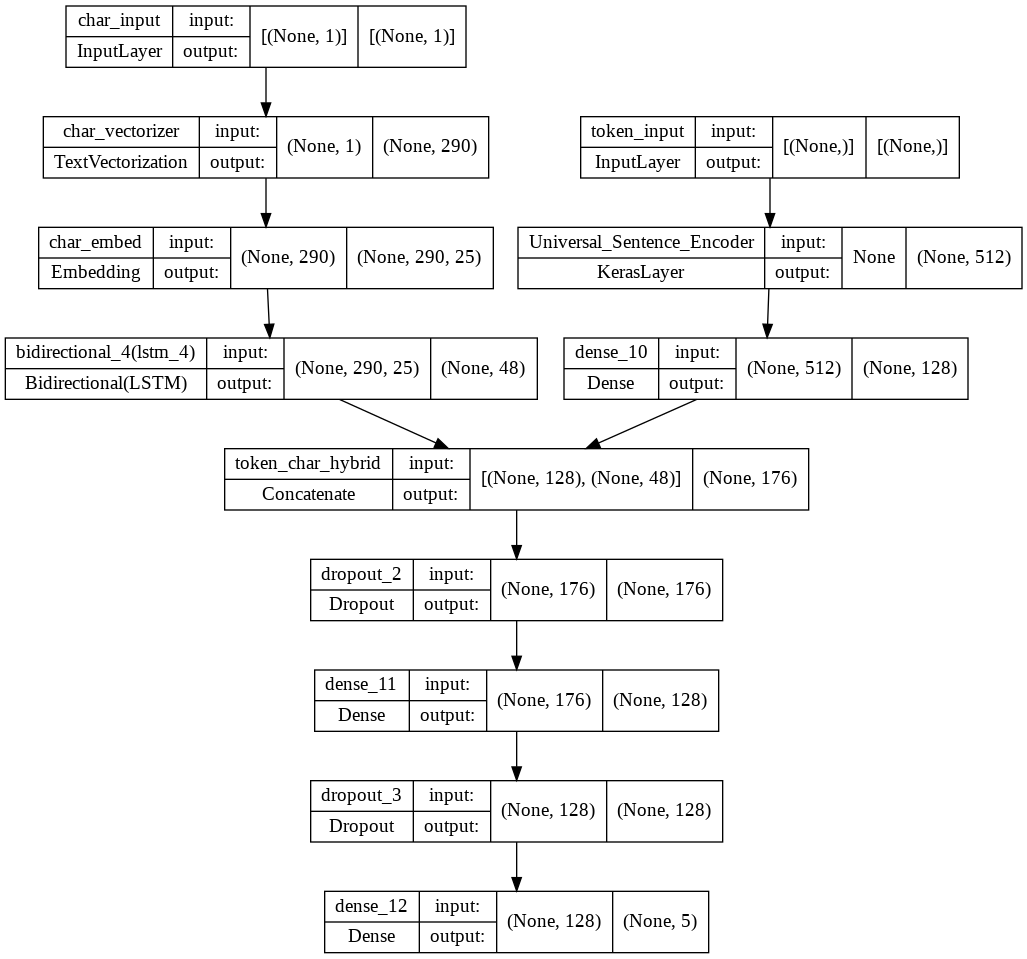

In [106]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes= True)

In [107]:
# Compile token char model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

### Combining token and char datasets before fitting

In [111]:
# Turn our data into Tensorflow Datasets

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

In [112]:
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [115]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

In [ ]:
val_char_token_dataset = val_char_token_dataset